# EE P 590: Deep Learning for Embedded Real-time Intelligence 


## Assignment 1 (Due April 17th 11:59 pm) 


**Note: You can use the codes and helper functions provided to you in the `Tutorial 1.ipynb` and `utils.py` files.**

In [351]:
# import torch 
from eep590_utils import *
import random

## Warm-up (25 points) 

**1) Plot the function $y = f(x) = x^3 - \frac{1}{x}$ and its tangent line when $x = 1$.**

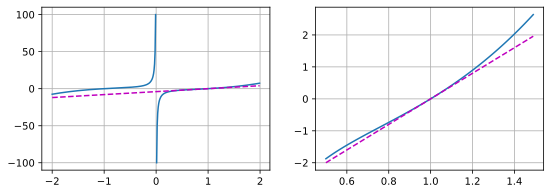

In [352]:
f = lambda x : x**3 - 1/x 
x1 = torch.arange(-2, 2, 0.01)
x2 = torch.arange(0.5, 1.5, 0.01)
df = lambda x: 4*x - 4

_, axes = plt.subplots(1, 2, figsize=(9, 3))
plot(x1, [f(x1), df(x1)], axes=axes[0])
plot(x2, [f(x2), df(x2)], axes=axes[1])

**2) Why is the second derivative much more expensive to compute than the first derivative?** 

In chain rule, the second derivative is much more expensive to compute than the first derivative.

For example, Assuming that y = f(u) and u = g(x), then the first derivative is:
$$ \frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx}$$
The second derivative is:
$$ \frac{d^2y}{dx^2} = \frac{d^2y}{du^2}(\frac{du}{dx})^2 + \frac{dy}{du} \frac{d^2u}{dx^2} $$


**3) Let $f(x) = \sin(x)$. Plot $f(x)$ and $\frac{df(x)}{dx}$, where the latter is computed using the inbuilt autograd feature of pytorch.**

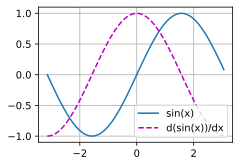

In [353]:
x = torch.arange(-torch.pi, torch.pi, 0.1)
x.requires_grad=True
y = torch.sin(x)
y.sum().backward()
x.grad

plot(x.detach(),[y.detach(), x.grad],legend = ["sin(x)", "d(sin(x))/dx"])

## Projection (15 points)

The projection of a vector $\mathbf{x}$ on a convex set $\mathcal{X}$ is defined as

$$\mathrm{Proj}_\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in \mathcal{X}} \|\mathbf{x} - \mathbf{x}'\|,$$

which is the closest point in $\mathcal{X}$ to $\mathbf{x}$. 

![Convex Projections.](projections.svg)

The mathematical definition of projections may sound a bit abstract. The figure explains it somewhat more clearly. In it we have two convex sets, a circle and a diamond. 
Points inside both sets (yellow) remain unchanged during projections. 
Points outside both sets (black) are projected to 
the points inside the sets (red) that are closet to the original points (black).
While for $L_2$ balls this leaves the direction of the vector unchanged, this need not be the case in general, as can be seen in the case of the diamond.


One of the uses for convex projections is to compute sparse weight vectors. In this case we project weight vectors onto an $L_1$ ball, which is a generalized version of the diamond case in the figure. Later in this course we will learn why sparsity is a powerful tool in embedded deep learning, and exploit sparsity for efficient real-time inference. 

**1) Given a convex set $\mathcal{X}$ and vectors $\mathbf{x}$ and $\mathbf{y}$, is the condition $\|\mathbf{x} - \mathbf{y}\| \geq \|\mathrm{Proj}_\mathcal{X}(\mathbf{x}) - \mathrm{Proj}_\mathcal{X}(\mathbf{y})\|$ always true? Explain your reasoning (we don't expect a formal mathematical proof, an intuitive explanation is sufficient)** 

Note: here $\|\mathbf{x} - \mathbf{y}\|$ represents the euclidean distance between $\mathbf{x}$ and $\mathbf{y}$

It is true. According to the definition of projection, because of the min distance of $\mathcal{x}$ in convex set is $\mathrm{Proj}_\mathcal{X}(\mathbf{x})$, the angle between the line segment A and the boundary of the convex set must be greater than or equal to 90. Then because of the definition of the convex set, the boundary of the convex set cannot have a concave shape, so the angle between $\mathrm{Proj}_\mathcal{X}(\mathbf{x})$, $\mathrm{Proj}_\mathcal{X}(\mathbf{y})$ and the boundary of the set must greater than 90. Therefore, $\mathbf{x}, \mathbf{y}$ must diffuse outward relative to $\mathrm{Proj}_\mathcal{X}(\mathbf{x})$, $\mathrm{Proj}_\mathcal{X}(\mathbf{y})$. That proof that $\|\mathbf{x} - \mathbf{y}\| \geq \|\mathrm{Proj}_\mathcal{X}(\mathbf{x}) - \mathrm{Proj}_\mathcal{X}(\mathbf{y})\|$ is true.

## Reduced bit-width weights (10 points)

We will learn later in the class that often it is sufficient to express weights of deep learning in reduced 4-bit or 8-bit  integer repsentations, instead of using real numbers (floating points or 32-bit representations). The process of doing so is called **quantization**. This reduces the memory required to store the weights in MCU units by a factor of 4 to 8, with a marginal trade-off for accuracy. 

**1) Consider the set of all the points that can be represented as $n$-bit integers and let's call the set as $\mathcal{X}_n$. For example, $\mathcal{X}_8$ will be a set of integers from $0$ to $255$. Is  $\mathcal{X}_4$ a convex set? What about $\mathcal{X}_n$ for a general $n$? Explain your reasoning.**


$\mathcal{X}_4$ is a convex set. $\mathcal{X}_n$ for a general $n$ is also a convex set. *(if only consider integers, not include float)* Because the set is continuous. For all $\lambda \in [0, 1]$, if $\lambda  a + (1-\lambda)  b$ is a integer. it have
$$\lambda  a + (1-\lambda)  b \in \mathcal{X} \text{ whenever } a, b \in \mathcal{X}.$$


## Linear Regression (20 points)

**1) Implement the closed-form (analytical) solution for linear regression (refer to lecture slides) and compare it with the parameters obtained using SGD in `tutorial 1.ipynb`. How does this problem and its solution relate to the normal distribution?**  


**2) In the linear regression example provided in tutorial 1, what would happen if we were to initialize the weights to zero. Would the algorithm work? Explain**

#### Generating the Dataset

In [354]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [355]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [356]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

#### SGD Method

In [357]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


def linreg(X, w, b):  
    """The linear regression model."""
    return torch.matmul(X, w) + b


def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


w = torch.zeros(size=(2,1), requires_grad=True)
#w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

batch_size = 10
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.032864
epoch 2, loss 0.000114
epoch 3, loss 0.000047


In [358]:
for X, y in zip(features, labels):
    l = squared_loss(linreg(X, w, b), y)  # Minibatch loss in `X` and `y`
    # Compute gradient on `l` with respect to [`w`, `b`]
    l.sum().backward()

#### Closed-Form LR

In [359]:
def closedForm_w(X, y):
    w  = torch.matmul(
            torch.matmul(
                torch.inverse(
                    torch.matmul(
                        torch.transpose(X, 0, 1),
                        X)),
                torch.transpose(X, 0, 1)),
            y)
    
    b = (torch.matmul(X, w) - y).mean()

    return w, b
    
lr_w, lr_b = closedForm_w(features, labels)

In [361]:
print(f'True w and b: {true_w.data.reshape(2)}, {true_b}')
print(f'SGD w and b: {w.data.reshape(2)}, {b.data}')
print(f'LR Closed-Form w and b: {lr_w.data.reshape(2)}, {lr_b.data}')

True w and b: tensor([ 2.0000, -3.4000]), 4.2
SGD w and b: tensor([ 1.9997, -3.3995]), tensor([4.1997])
LR Closed-Form w and b: tensor([ 1.9106, -3.6192]), -4.186424732208252


From the result, we can see that the closed-form solutions have the bigger error that SGD solution.

SGD is based on Gradient Descent to make the results gradually close to the real parameters. The closed-form solution only calculates the average value based on the X and y of all data. When there is noise in the data, the results obtained using closed-form will have greater errors

#### 2)
The algorithm still work, because we are using "+" or "-" to update the weights in linear regression by gradients, not multiples. No mater what initialized weights we set, the weight will be update in linear regression by add/subtract the gradients, so it will work no mater which weights we initialized.

## Momentum (30 points)

In the class lecture and the tutorial we reviewed stochastic gradient descent, i.e., when performing optimization where only a noisy variant of the gradient is available. For noisy gradients we need to be extra cautious when it comes to choosing the learning rate in the face of noise. If we decrease it too rapidly, convergence stalls. If we are too lenient, we fail to converge to a good enough solution since noise keeps on driving us away from optimality. Here we will explore more effective optimization algorithms, especially for certain types of optimization problems that are common in practice.


#### Leaky Averages

In the lecture we discussed minibatch SGD as a means for accelerating computation. It also had the nice side-effect that averaging gradients reduced the amount of variance. The minibatch stochastic gradient descent can be calculated by:

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
$$

To keep the notation simple, here we used $\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$ as the stochastic gradient descent for sample $i$ using the weights updated at time $t-1$.
It would be nice if we could benefit from the effect of variance reduction even beyond averaging gradients on a minibatch. One option to accomplish this task is to replace the gradient computation by a "leaky average":

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$$

for some $\beta \in (0, 1)$. This effectively replaces the instantaneous gradient by one that's been averaged over multiple *past* gradients. $\mathbf{v}$ is called *momentum*. It accumulates past gradients similar to how a heavy ball rolling down the objective function landscape integrates over past forces. To see what is happening in more detail let us expand $\mathbf{v}_t$ recursively into

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$

Large $\beta$ amounts to a long-range average, whereas small $\beta$ amounts to only a slight correction relative to a gradient method. The new gradient replacement no longer points into the direction of steepest descent on a particular instance any longer but rather in the direction of a weighted average of past gradients. This allows us to realize most of the benefits of averaging over a batch without the cost of actually computing the gradients on it. We will revisit this averaging procedure in more detail later.

The above reasoning formed the basis for what is now known as *accelerated* gradient methods, such as gradients with momentum. They enjoy the additional benefit of being much more effective in cases where the optimization problem is ill-conditioned (i.e., where there are some directions where progress is much slower than in others, resembling a narrow canyon). Furthermore, they allow us to average over subsequent gradients to obtain more stable directions of descent. Indeed, the aspect of acceleration even for noise-free convex problems is one of the key reasons why momentum works and why it works so well.

#### An Ill-conditioned Example

To get a better understanding of the geometric properties of the momentum method we revisit gradient descent, albeit with a significantly less pleasant objective function. We distort an ellipsoid function by stretching it out in the $x_1$ direction via

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

$f$ has its minimum at $(0, 0)$. This function is *very* flat in the direction of $x_1$. Let us see what happens when we perform gradient descent as before on this new function. We pick a learning rate of $0.4$.


epoch 20, x1: -0.943467, x2: -0.000073


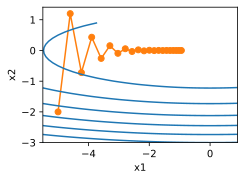

In [ ]:
eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

By construction, the gradient in the $x_2$ direction is *much* higher and changes much more rapidly than in the horizontal $x_1$ direction. Thus we are stuck between two undesirable choices: if we pick a small learning rate we ensure that the solution does not diverge in the $x_2$ direction but we are saddled with slow convergence in the $x_1$ direction. Conversely, with a large learning rate we progress rapidly in the $x_1$ direction but diverge in $x_2$. The example below illustrates what happens even after a slight increase in learning rate from $0.4$ to $0.6$. Convergence in the $x_1$ direction improves but the overall solution quality is much worse.


epoch 20, x1: -0.387814, x2: -1673.365109


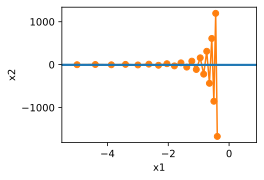

In [ ]:
eta = 0.6
show_trace_2d(f_2d, train_2d(gd_2d))

### The Momentum Method

The momentum method allows us to solve the gradient descent problem described
above. Looking at the optimization trace above we might intuit that averaging gradients over the past would work well. After all, in the $x_1$ direction this will aggregate well-aligned gradients, thus increasing the distance we cover with every step. Conversely, in the $x_2$ direction where gradients oscillate, an aggregate gradient will reduce step size due to oscillations that cancel each other out.
Using $\mathbf{v}_t$ instead of the gradient $\mathbf{g}_t$ yields the following update equations:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

Note that for $\beta = 0$ we recover regular gradient descent. Let us have a quick look at how the algorithm behaves in practice.


epoch 20, x1: 0.007188, x2: 0.002553


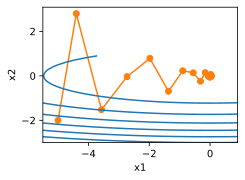

In [ ]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

As we can see, even with the same learning rate that we used before, momentum still converges well. 

Note that we can combine momentum with stochastic gradient descent and in particular, minibatch stochastic gradient descent. Let us see how momentum works in practice, i.e., when used within the context of a proper optimizer. For this we need a somewhat more scalable implementation.

### 1) Implementation (complete the modules so that this works end-to-end)

Compared with (minibatch) stochastic gradient descent the momentum method needs to maintain a set of  auxiliary variables, i.e., velocity. It has the same shape as the gradients (and variables of the optimization problem). In the implementation below we call these variables `states`.


In [ ]:
def init_momentum_states(feature_dim):
    '''Complete this module and return _momentum_states'''
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    _momentum_states = [w,b]
    return _momentum_states

In [ ]:
def sgd_momentum(params, states, hyperparams):
    '''Complete this module. You can refer to sgd() module in the tutorial for a reference '''
    with torch.no_grad():
        for param, state in zip(params, states):
            state[:] = hyperparams['momentum'] * state + param.grad
            param[:] -= hyperparams['lr'] * state
            param.grad.zero_()


## Reading the Dataset

In the following we use a dataset developed by NASA to test the wing [noise from different aircraft](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) For convenience we only use the first $1,500$ examples. The data is whitened for preprocessing, i.e., we remove the mean and rescale the variance to $1$ per coordinate.

In [ ]:
def get_data(batch_size=10, n=1500):
    data = np.genfromtxt('airfoil_self_noise.dat',
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

Next, we implement a generic training function to facilitate the use of the other optimization algorithms introduced later in this chapter. It initializes a linear regression model and can be used to train the model with minibatch stochastic gradient descent and other algorithms introduced subsequently.


In [ ]:
def _train(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    # Train
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.243, 0.005 sec/epoch


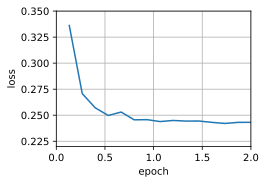

In [ ]:
def train_momentum(lr, momentum, num_epochs=2):
    _train(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = get_data(batch_size=10)
train_momentum(0.02, 0.5)

loss: 0.244, 0.005 sec/epoch


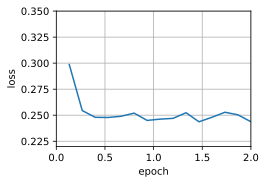

In [ ]:
train_momentum(0.01, 0.9)

loss: 0.245, 0.005 sec/epoch


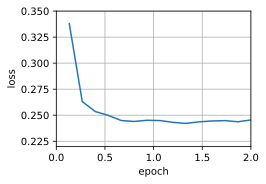

In [ ]:
train_momentum(0.005, 0.9)

#### Momentum for Scalar Functions

Now, let us see what happens when we minimize the function $f(x) = \frac{\lambda}{2} x^2$. For gradient descent we have

$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$$

Whenever $|1 - \eta \lambda| < 1$ this optimization converges at an exponential rate since after $t$ steps we have $x_t = (1 - \eta \lambda)^t x_0$. This shows how the rate of convergence improves initially as we increase the learning rate $\eta$ until $\eta \lambda = 1$. Beyond that things diverge and for $\eta \lambda > 2$ the optimization problem diverges.


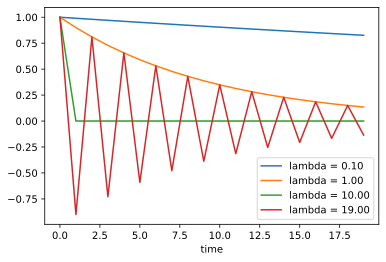

In [ ]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
plt.xlabel('time')
plt.legend();

**2) Analyze the conditions for convergence in case we use momentum instead of SGD. What are the feasible values of  $\eta \lambda$ for convergence? Is the range of feasible paramenters larger when compared to $0 < \eta \lambda < 2$ for gradient descent?.**

In the case of momentum, the update equations will be:
$$
\begin{aligned}
\mathbf{v}_{t+1} &= \beta \mathbf{v}_{t} + \lambda \mathbf{x}_{t} \\
\mathbf{x}_{t+1} &= \mathbf{x}_{t} - \eta \mathbf{v}_{t+1}.
\end{aligned}
$$

Combine two equations, will have
$$ \mathbf{x}_{t+1} = (1 - \eta \lambda) \mathbf{x}_{t} - \eta \beta \mathbf{v}_{t} $$

Now the range of feasible values of $\eta \lambda$ for convergence is:
$$0 < \eta \lambda < 2 + 2\beta \ \ \ \ for \ \ \ \ 0 \le \beta < 1 $$

The range of feasible parameters for momentum is larger compared to $0 < \eta \lambda < 2$ for gradient descent.
